# Correlational Analysis Between Public Transit Access and Traffic Rates

Kendrick Nguyen, A16045878

# Dataset

**California Open Data: CA Transit Stops**
* Source: https://data.ca.gov/dataset/ca-transit-stops
* Description: Geospatial data on all transit stops in California across numerous transit agencies. Dataset was extracted as of 11/24/2024.

Selected Features:

| Feature    | Description   |
| :-------------| :-------------|
| X | Longitude coordinate |
| Y | Latitude coordinate |
| agency | Transit agencies in CA |
| route_id | Route name |
| stop_name | Stop Name |

**California Open Data: Traffic Volumes AADT**
* Source: https://data.ca.gov/dataset/traffic-volumes-aadt
* Description: Sampled traffic volume data in California. Volume is measured either in Annual Average Daily Traffic (AADT) or Monthly Average Daily Traffic (MADT). AADT is defined as the average number of vehicles passing a specific point on a road per day, calculated over the entire year. MADT is defind as the average number of vehicles passing a specific point on a road per day during a given month. This data is utilized to picture traffic flow, evaluate traffic trends, compute accident rates, plan and design highways and other purposes. Additionally, "very few locations in California are actually counted continuously" of this dataset.

Selected Features:

| Feature    | Description   |
| :-------------| :-------------|
| X | Longitude coordinate |
| Y | Latitude coordinate |
| back_peak_madt | Back Peak MADT, average daily traffic volume in the backward direction (e.g. away from a road, city, etc.) over a month|
| back_aadt | Back Peak AADT, average daily traffic volume in the backward direction over a year|
| ahead_peak_madt | Ahead Peak MADT, average daily traffic volume in the forward direction (e.g. toward a road, city, etc.) over a month|
| ahead_aadt | Ahead Peak AADT, average daily traffic volume in the forward direction over a year|

# Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point

import pysal
from pysal.explore import esda
from pysal.lib import weights
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/kendrick/anaconda3/envs/ECE225_FA24/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
transit_gdf = gpd.read_file("data/CA_Transit_Stops.geojson")
traffic_gdf = gpd.read_file("data/Traffic_Volumes_AADT.geojson")

In [3]:
# Cleaning and filtering
transit_gdf = transit_gdf[['agency', 'route_id', 'stop_name', 'geometry']].copy()
transit_gdf.columns = transit_gdf.columns.str.lower()

taffic_volume_features = ['BACK_PEAK_MADT', 'BACK_AADT', 'AHEAD_PEAK_MADT', 'AHEAD_AADT']
traffic_gdf[taffic_volume_features] = traffic_gdf[taffic_volume_features].apply(pd.to_numeric, errors='coerce')
traffic_gdf = traffic_gdf[['geometry'] + taffic_volume_features].copy()

traffic_gdf.columns = traffic_gdf.columns.str.lower()
taffic_volume_features = [feature.lower() for feature in taffic_volume_features]

In [4]:
# Set bounding rectangle, specified in metadata
# https://www.arcgis.com/sharing/rest/content/items/d8833219913c44358f2a9a71bda57f76/info/metadata/metadata.xml?format=default&output=html

WEST_BOUND = -124.350167
EAST_BOUND = -113.675266
NORTH_BOUND = 42.068401
SOUTH_BOUND = 32.444107

def filter_within_california(gdf):
    return gdf[
        (gdf.geometry.x >= WEST_BOUND) & (gdf.geometry.x <= EAST_BOUND) &
        (gdf.geometry.y >= SOUTH_BOUND) & (gdf.geometry.y <= NORTH_BOUND)
    ]

In [5]:
transit_gdf.set_crs("EPSG:4326", inplace=True)
transit_gdf.dropna(inplace=True)
transit_gdf = filter_within_california(transit_gdf)

traffic_gdf.set_crs("EPSG:4326", inplace=True)
traffic_gdf.dropna(inplace=True)
traffic_gdf = filter_within_california(traffic_gdf)

In [6]:
transit_gdf.head()

,agency,route_id,stop_name,geometry
0,City of Alhambra,BlueLine,Chapel Ave & Bay St,POINT (-118.12 34.095)
1,City of Alhambra,BlueLine,Chapel Ave & Main St,POINT (-118.12 34.096)
2,City of Alhambra,BlueLine,Chapel Ave & Woodward Ave,POINT (-118.13 34.099)
3,City of Alhambra,BlueLine,Woodward Ave & Garfield Ave,POINT (-118.13 34.098)
4,City of Alhambra,BlueLine,Garfield Ave & Main St,POINT (-118.13 34.095)


In [7]:
traffic_gdf.head()

,geometry,back_peak_madt,back_aadt,ahead_peak_madt,ahead_aadt
0,POINT (-117.22 32.9),94000.0,80000.0,51000.0,46000.0
1,POINT (-117.22 32.901),55000.0,50000.0,46500.0,40000.0
2,POINT (-117.22 32.904),82000.0,70000.0,63000.0,60000.0
4,POINT (-117.98 33.854),243000.0,223000.0,147000.0,133900.0
5,POINT (-117.98 33.856),147000.0,133900.0,147000.0,133900.0


# Data Exploration

In [8]:
# California shape
california_shapefile = 'data/ca_counties.zip'
california = gpd.read_file(california_shapefile)
california = california.to_crs(epsg=4326)

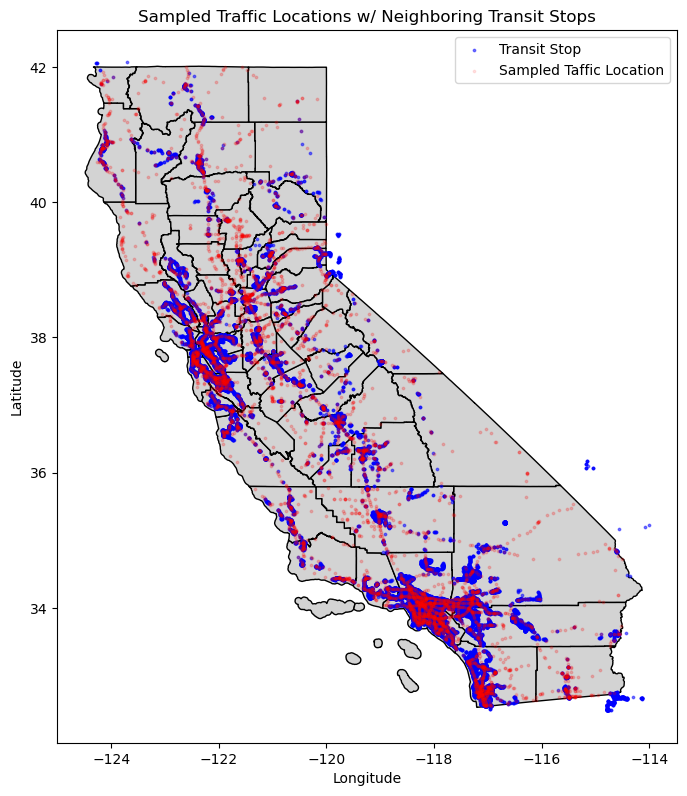

In [9]:
fig, ax = plt.subplots(figsize=(8, 10))
california.plot(ax=ax, color='lightgray', edgecolor='black')

transit_gdf.plot(ax=ax, color='blue', markersize=3, alpha=0.5, label='Transit Stop')
traffic_gdf.plot(ax=ax, color='red', markersize=3, alpha=0.1, label='Sampled Taffic Location')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

plt.title("Sampled Traffic Locations w/ Neighboring Transit Stops")
plt.show()

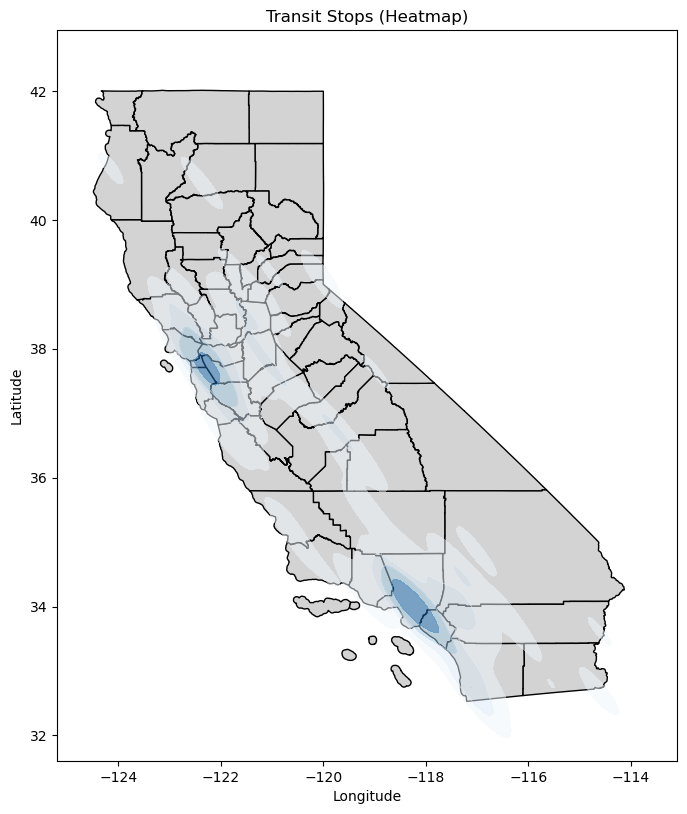

In [10]:
# Plot dense area with transit stops
transit_coordinates = np.array(list(zip(transit_gdf.geometry.x, transit_gdf.geometry.y)))

fig, ax = plt.subplots(figsize=(8, 10))
california.plot(ax=ax, color='lightgray', edgecolor='black')

sns.kdeplot(
    x=transit_coordinates[:, 0],
    y=transit_coordinates[:, 1],
    ax=ax,
    cmap="Blues",
    fill=True,
    alpha=0.5,
    levels=5,
)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.title("Transit Stops (Heatmap)")
plt.show()

In [11]:
# Appears LA and SF are heavily dense areas, take roughly their center
la_center = Point(-118.7413812, 34.0200392)
sf_center = Point(-122.520001, 37.7576713)

In [12]:
def get_neighbors(point, gdf, distance_thresh=0):
    utm_gdf = gdf.to_crs(epsg=32610)
    utm_point = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(utm_gdf.crs).iloc[0]
    
    utm_gdf['distance'] = utm_gdf.geometry.distance(utm_point)
    neighbors = utm_gdf[utm_gdf['distance'] <= distance_thresh]
    
    return neighbors

In [13]:
# Roughly 50, 10, 5, 1, 0.1 miles
distance_buffer = [80000, 16000, 8000, 1600, 160]
la_neighboring_transits = {}
sf_neighboring_transits = {}


for distance in distance_buffer:
    neighbors = get_neighbors(la_center, transit_gdf, distance)
    la_neighboring_transits.update({distance: neighbors})
    
    neighbors = get_neighbors(sf_center, transit_gdf, distance)
    sf_neighboring_transits.update({distance: neighbors})

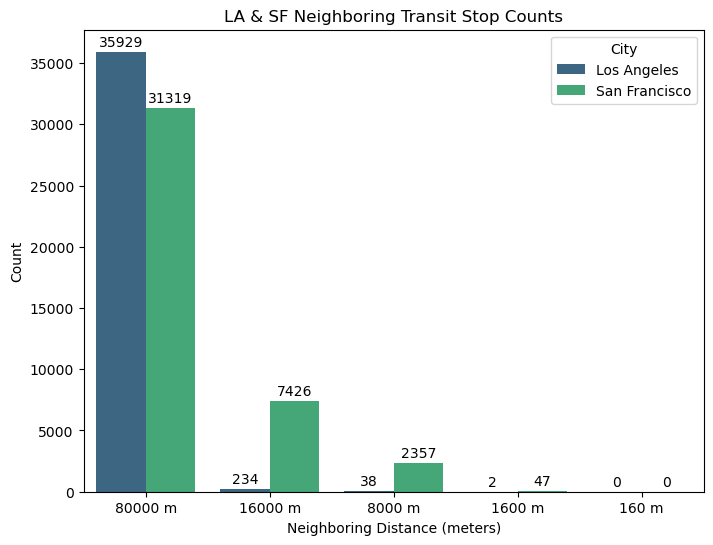

In [14]:
temp = []
for distance in distance_buffer:
    la_count = len(la_neighboring_transits[distance])
    sf_count = len(sf_neighboring_transits[distance])
    temp.append({'distance': f"{distance} m", 'city': 'Los Angeles', 'transit_count': la_count})
    temp.append({'distance': f"{distance} m", 'city': 'San Francisco', 'transit_count': sf_count})

plt.figure(figsize=(8, 6))
temp = pd.DataFrame(temp)

ax = sns.barplot(temp, x='distance', y='transit_count', hue='city', palette='viridis')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=2)

plt.xlabel('Neighboring Distance (meters)')
plt.ylabel('Count')
plt.title('LA & SF Neighboring Transit Stop Counts')
plt.legend(title='City')

plt.show()

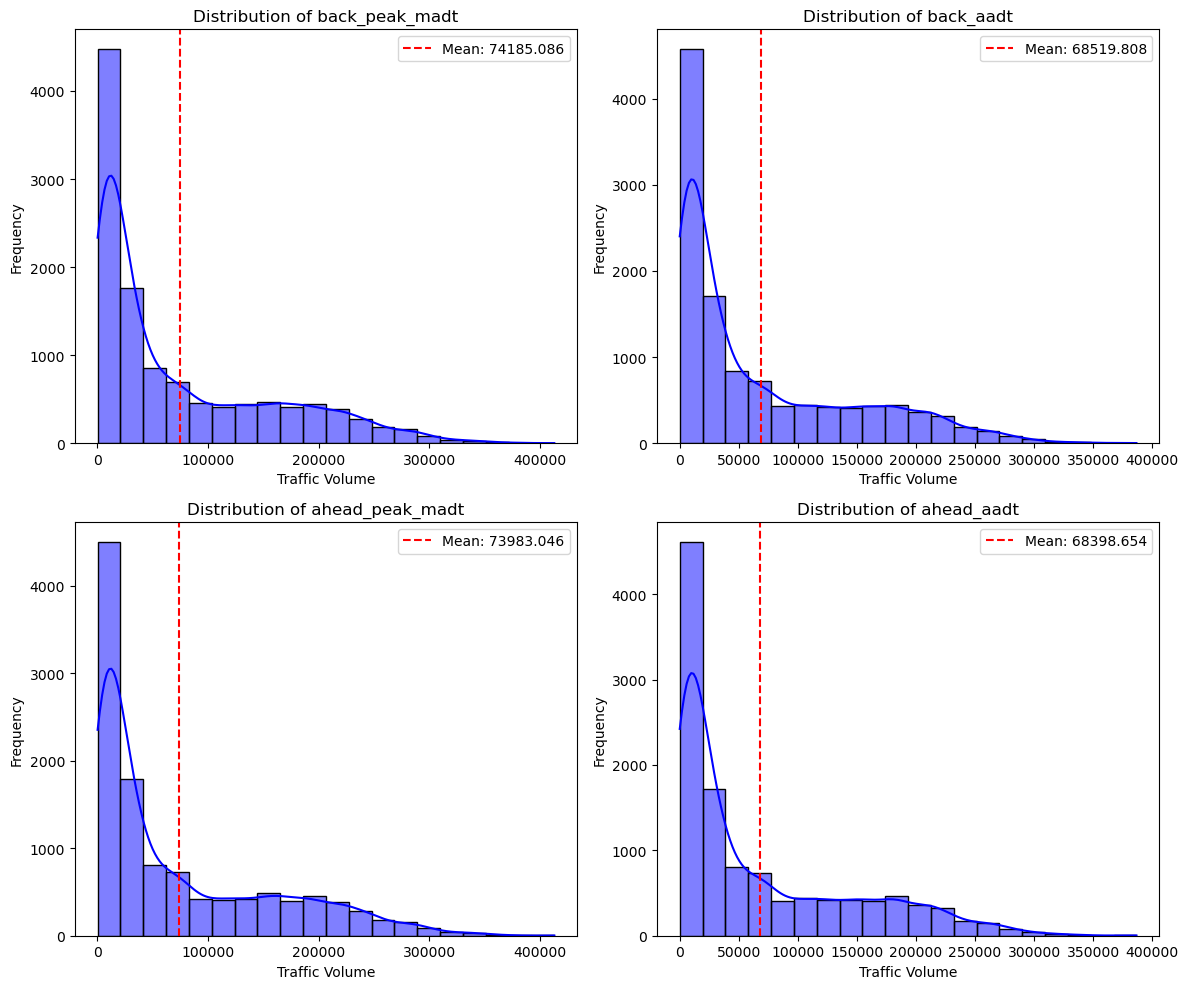

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(taffic_volume_features):
    mean = traffic_gdf[column].mean()

    sns.histplot(traffic_gdf[column], kde=True, ax=axes[i], bins=20, color='blue')
    axes[i].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.3f}')

    # Add titles, labels, and legend
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel('Traffic Volume')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Correlational Analysis Using Proximity Analysis

In [16]:
correl_transit_gdf = transit_gdf.to_crs(epsg=32610)
correl_traffic_gdf = traffic_gdf.to_crs(epsg=32610)

In [17]:
# Try 80000m using spatial join
distance = 80000

correl_traffic_gdf['buffer'] = correl_traffic_gdf.geometry.buffer(distance)

# Spatial join
buffer_gdf = correl_traffic_gdf[['buffer']].set_geometry('buffer')
joined_gdf = sjoin(buffer_gdf, correl_transit_gdf, how='left', predicate='contains')
transit_counts = joined_gdf.groupby(joined_gdf.index).size()

correl_traffic_gdf['num_transit_stops'] = correl_traffic_gdf.index.map(transit_counts).fillna(0).astype(int)
correl_traffic_gdf.drop(columns=['buffer'], inplace=True)

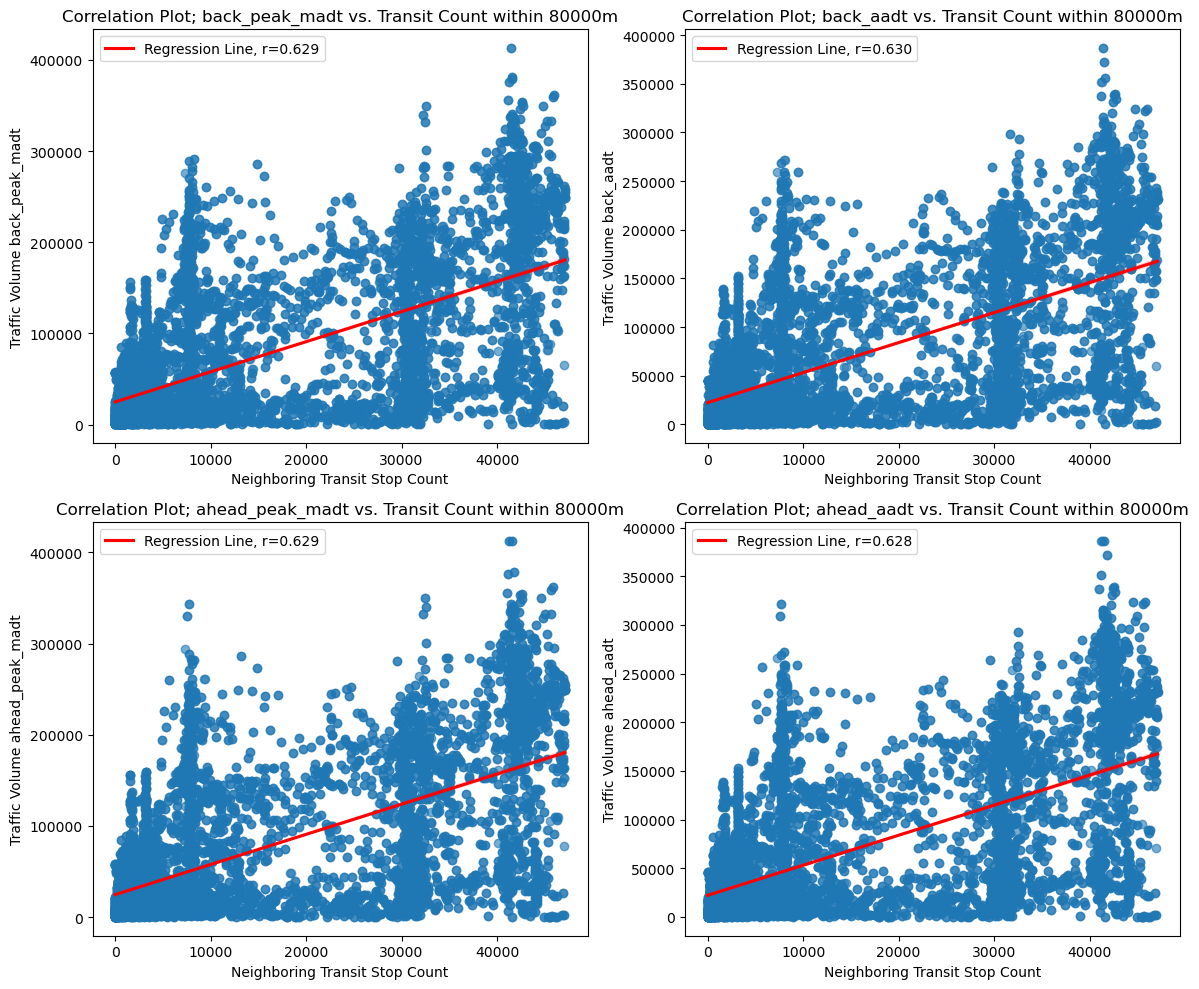

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(taffic_volume_features):    
    corr, _ = pearsonr(correl_traffic_gdf['num_transit_stops'], correl_traffic_gdf[column])
    sns.regplot(
        x=correl_traffic_gdf['num_transit_stops'],
        y=correl_traffic_gdf[column],
        ax=axes[i],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red', 'label': f'Regression Line, r={corr:.3f}'}
    )

    # Add titles, labels, and legend
    axes[i].set_title(f'Correlation Plot; {column} vs. Transit Count within {distance}m')
    axes[i].set_xlabel('Neighboring Transit Stop Count')
    axes[i].set_ylabel(f'Traffic Volume {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [19]:
# Try 16000m using spatial join
distance = 16000

correl_traffic_gdf['buffer'] = correl_traffic_gdf.geometry.buffer(distance)

# Spatial join
buffer_gdf = correl_traffic_gdf[['buffer']].set_geometry('buffer')
joined_gdf = sjoin(buffer_gdf, correl_transit_gdf, how='left', predicate='contains')
transit_counts = joined_gdf.groupby(joined_gdf.index).size()

correl_traffic_gdf['num_transit_stops'] = correl_traffic_gdf.index.map(transit_counts).fillna(0).astype(int)
correl_traffic_gdf.drop(columns=['buffer'], inplace=True)

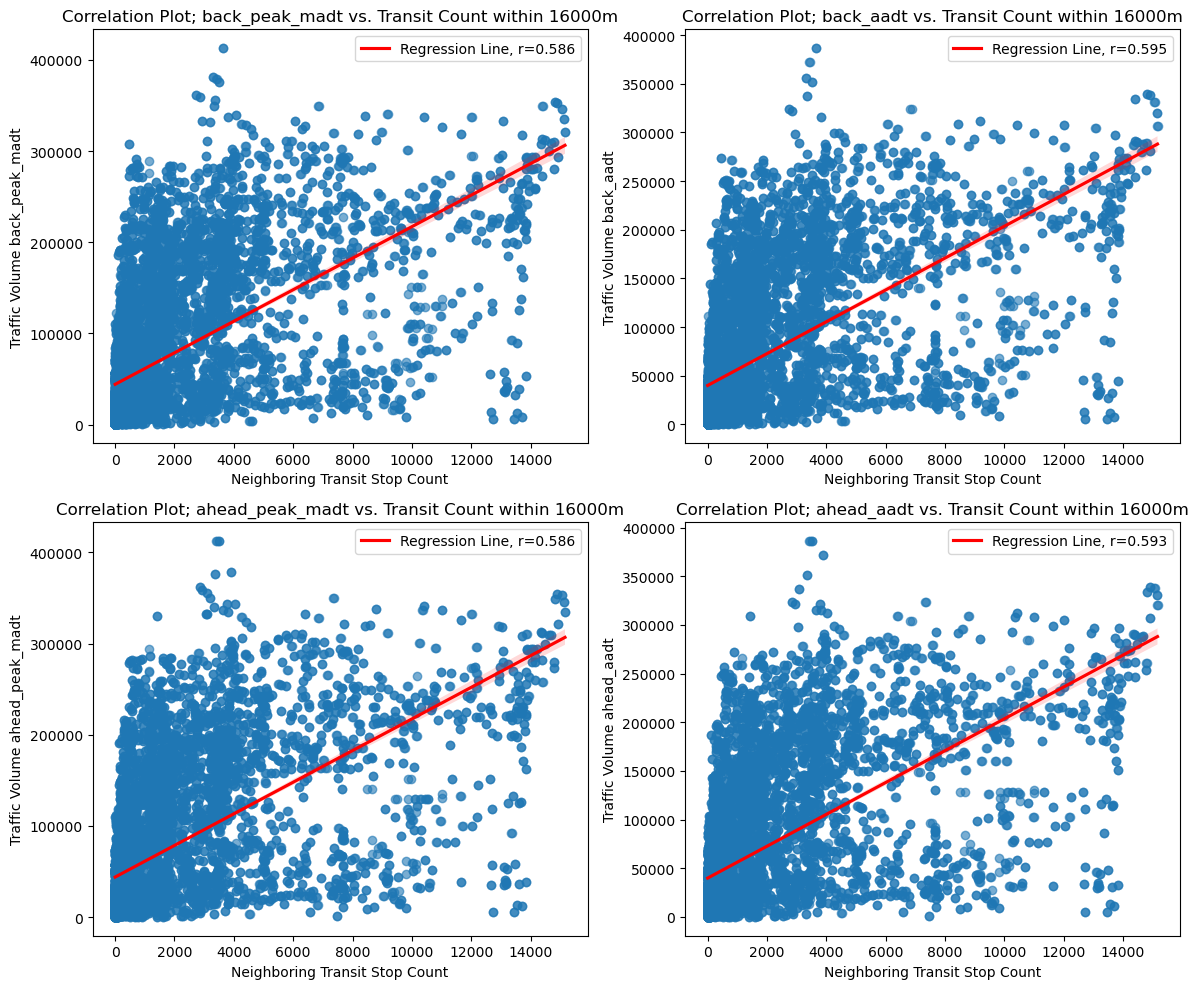

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(taffic_volume_features):    
    corr, _ = pearsonr(correl_traffic_gdf['num_transit_stops'], correl_traffic_gdf[column])
    sns.regplot(
        x=correl_traffic_gdf['num_transit_stops'],
        y=correl_traffic_gdf[column],
        ax=axes[i],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red', 'label': f'Regression Line, r={corr:.3f}'}
    )

    # Add titles, labels, and legend
    axes[i].set_title(f'Correlation Plot; {column} vs. Transit Count within {distance}m')
    axes[i].set_xlabel('Neighboring Transit Stop Count')
    axes[i].set_ylabel(f'Traffic Volume {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [21]:
# Location specific: LA
# Find sample of traffic points around LA and get their surrounding transit stop count
distance = 80000
correl_traffic_gdf = traffic_gdf.to_crs(epsg=32610)
correl_traffic_gdf = get_neighbors(la_center, correl_traffic_gdf, distance)

correl_traffic_gdf['buffer'] = correl_traffic_gdf.geometry.buffer(distance)

# Spatial join
buffer_gdf = correl_traffic_gdf[['buffer']].set_geometry('buffer')
joined_gdf = sjoin(buffer_gdf, correl_transit_gdf, how='left', predicate='contains')
transit_counts = joined_gdf.groupby(joined_gdf.index).size()

correl_traffic_gdf['num_transit_stops'] = correl_traffic_gdf.index.map(transit_counts).fillna(0).astype(int)
correl_traffic_gdf.drop(columns=['buffer'], inplace=True)

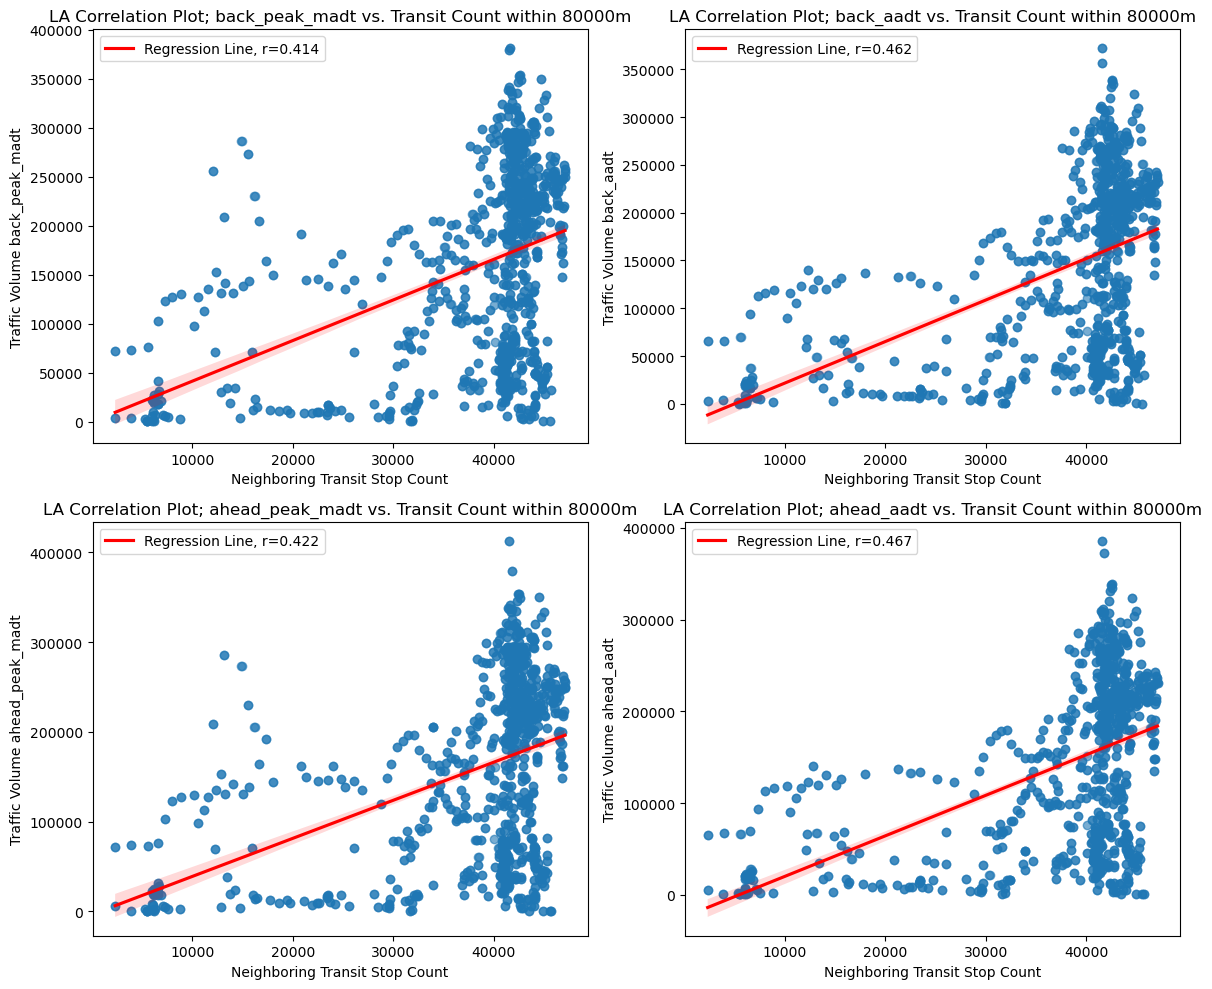

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(taffic_volume_features):    
    corr, _ = pearsonr(correl_traffic_gdf['num_transit_stops'], correl_traffic_gdf[column])
    sns.regplot(
        x=correl_traffic_gdf['num_transit_stops'],
        y=correl_traffic_gdf[column],
        ax=axes[i],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red', 'label': f'Regression Line, r={corr:.3f}'}
    )

    # Add titles, labels, and legend
    axes[i].set_title(f'LA Correlation Plot; {column} vs. Transit Count within {distance}m')
    axes[i].set_xlabel('Neighboring Transit Stop Count')
    axes[i].set_ylabel(f'Traffic Volume {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [23]:
# Location specific: SF
# Find sample of traffic points around SF and get their surrounding transit stop count
distance = 80000
correl_traffic_gdf = traffic_gdf.to_crs(epsg=32610)
correl_traffic_gdf = get_neighbors(sf_center, correl_traffic_gdf, distance)

correl_traffic_gdf['buffer'] = correl_traffic_gdf.geometry.buffer(distance)

# Spatial join
buffer_gdf = correl_traffic_gdf[['buffer']].set_geometry('buffer')
joined_gdf = sjoin(buffer_gdf, correl_transit_gdf, how='left', predicate='contains')
transit_counts = joined_gdf.groupby(joined_gdf.index).size()

correl_traffic_gdf['num_transit_stops'] = correl_traffic_gdf.index.map(transit_counts).fillna(0).astype(int)
correl_traffic_gdf.drop(columns=['buffer'], inplace=True)

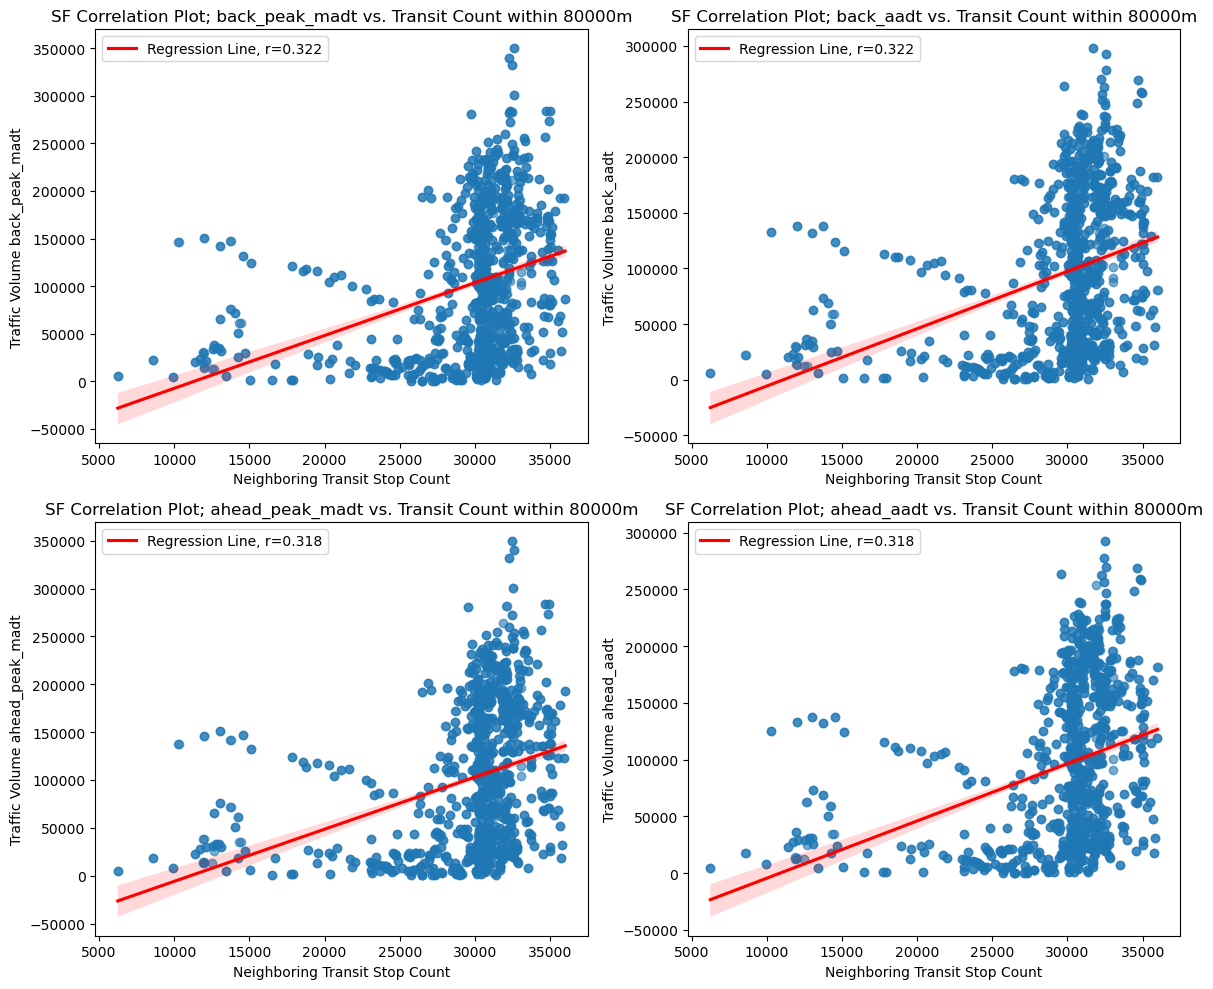

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(taffic_volume_features):    
    corr, _ = pearsonr(correl_traffic_gdf['num_transit_stops'], correl_traffic_gdf[column])
    sns.regplot(
        x=correl_traffic_gdf['num_transit_stops'],
        y=correl_traffic_gdf[column],
        ax=axes[i],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red', 'label': f'Regression Line, r={corr:.3f}'}
    )

    # Add titles, labels, and legend
    axes[i].set_title(f'SF Correlation Plot; {column} vs. Transit Count within {distance}m')
    axes[i].set_xlabel('Neighboring Transit Stop Count')
    axes[i].set_ylabel(f'Traffic Volume {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Spatial Autocorrelation

In [25]:
w_traffic = weights.KNN.from_dataframe(traffic_gdf, k=20)
moran_i_models = {}

for column in taffic_volume_features: 
    moran = esda.Moran(traffic_gdf[column], w_traffic)
    moran_i_models.update({column: moran})

    print(f"Moran's I {column}: {moran.I}")
    print(f"p-value: {moran.p_sim}")
    print("")

/Users/kendrick/anaconda3/envs/ECE225_FA24/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Moran's I back_peak_madt: 0.7357674575673209
p-value: 0.001

Moran's I back_aadt: 0.7406897734032772
p-value: 0.001

Moran's I ahead_peak_madt: 0.7361566615314548
p-value: 0.001

Moran's I ahead_aadt: 0.7398887986816225
p-value: 0.001



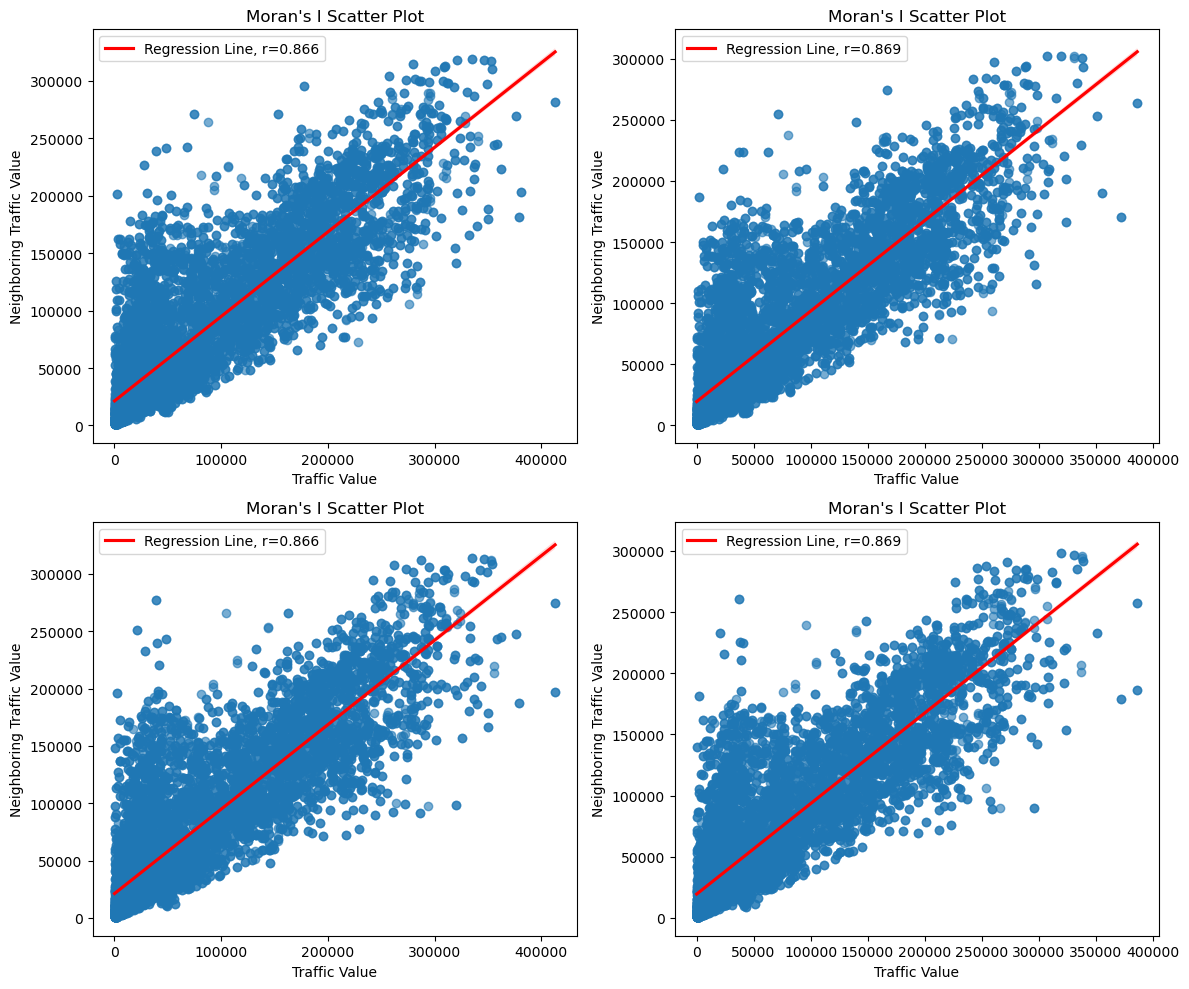

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

n_samples = traffic_gdf.shape[0]

for i, column in enumerate(taffic_volume_features):
    spatial_lag = [w_traffic.sparse[i].multiply(traffic_gdf[column]).sum() for i in range(n_samples)]
    corr, _ = pearsonr(traffic_gdf[column], spatial_lag)
    sns.regplot(
        x=traffic_gdf[column],
        y=spatial_lag,
        ax=axes[i],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red', 'label': f'Regression Line, r={corr:.3f}'}
    )

    # Add titles, labels, and legend
    axes[i].set_title('Moran\'s I Scatter Plot')
    axes[i].set_xlabel('Traffic Value')
    axes[i].set_ylabel('Neighboring Traffic Value')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [27]:
correl_transit_gdf = transit_gdf.to_crs(epsg=3395)
correl_traffic_gdf = traffic_gdf.to_crs(epsg=3395)

# Calculate distance between traffic points and nearest transit stops
correl_traffic_gdf['min_transit'] = correl_traffic_gdf['geometry'].distance(correl_transit_gdf.unary_union)

/var/folders/_2/txdcmxgd53qf3zt_54lvqf1w0000gn/T/ipykernel_2045/3974062746.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  correl_traffic_gdf['min_transit'] = correl_traffic_gdf['geometry'].distance(correl_transit_gdf.unary_union)


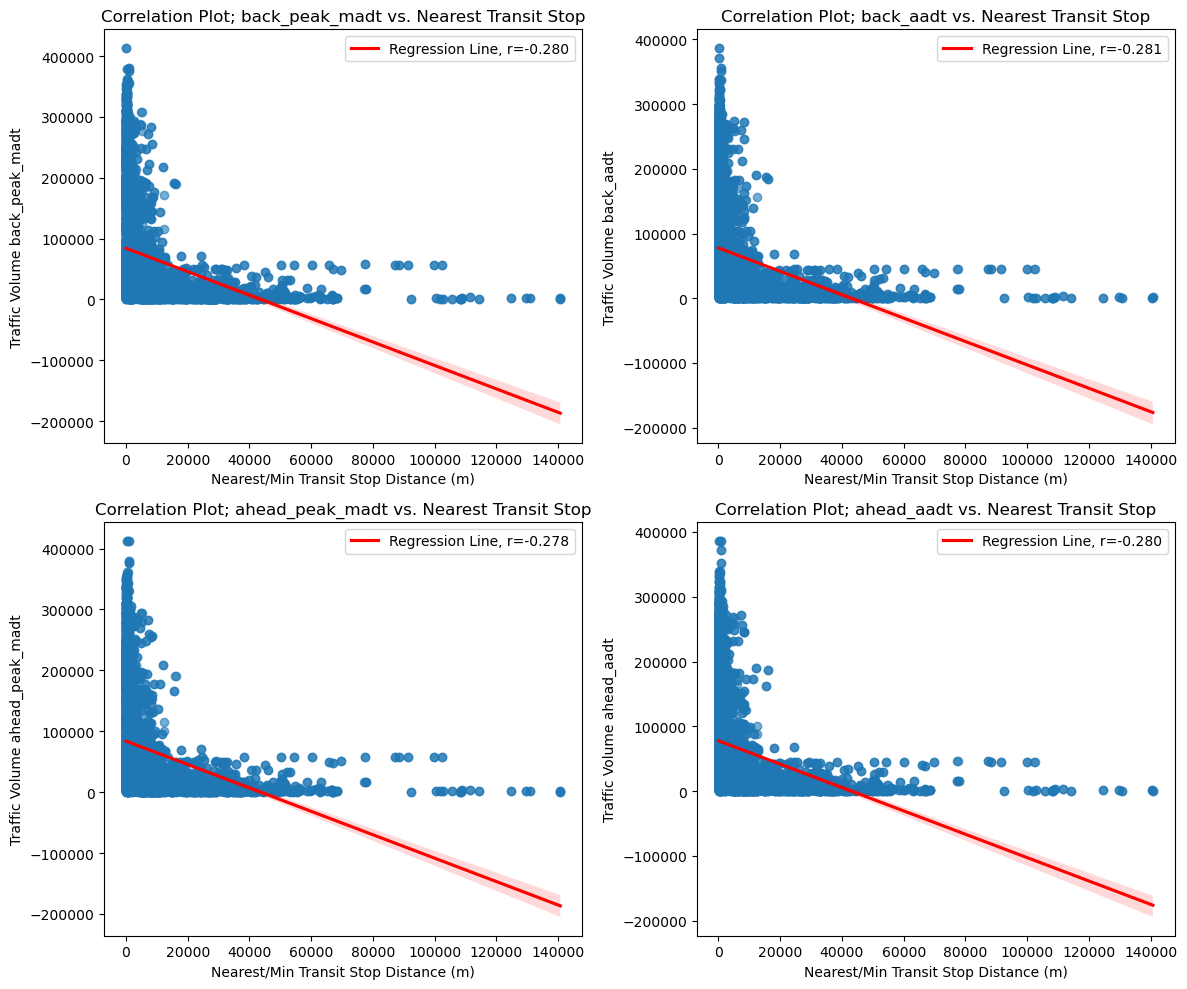

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, column in enumerate(taffic_volume_features):
    corr, _ = pearsonr(correl_traffic_gdf['min_transit'], correl_traffic_gdf[column])
    sns.regplot(
        x=correl_traffic_gdf['min_transit'],
        y=traffic_gdf[column],
        ax=axes[i],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red', 'label': f'Regression Line, r={corr:.3f}'}
    )

    # Add titles, labels, and legend
    axes[i].set_title(f'Correlation Plot; {column} vs. Nearest Transit Stop')
    axes[i].set_xlabel('Nearest/Min Transit Stop Distance (m)')
    axes[i].set_ylabel(f'Traffic Volume {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()